In [1]:
import os
import requests
import pandas as pd
from pandas.tseries.offsets import MonthEnd, QuarterEnd, YearEnd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from arch import arch_model


In [2]:
api_key = ''
url =  "https://api.stlouisfed.org/fred/series/observations"
params = {
    "series_id":         "NASDAQ100",
    "api_key":           api_key,
    "file_type":         "json",
    "observation_start": "2010-01-01",  # adjust as needed
    "observation_end":   datetime.today().strftime("%Y-%m-%d")
}


In [3]:
r = requests.get(url, params=params)
r.raise_for_status()
data = r.json()["observations"]






In [4]:
df = pd.DataFrame(data)

df["date"]  = pd.to_datetime(df["date"])
df["value"] = pd.to_numeric(df["value"], errors="coerce")

df['value'] = df['value'].interpolate(method = 'linear', limit_direction = 'both',
                                      axis=0)
df = df.set_index("date")[["value"]].rename(columns={"value": "close"})

In [5]:
df['return'] = 1 - (df["close"] / df["close"].shift(1))
df["log_return"] = (df["close"] / df["close"].shift(1)).apply(lambda x: np.log(x))

In [6]:
df.iloc[3385:3395]

,close,return,log_return
date,,,
2022-12-23,10985.45,-0.002675,0.002672
2022-12-26,10903.98,0.007416,-0.007444
2022-12-27,10822.51,0.007472,-0.007500
2022-12-28,10679.34,0.013229,-0.013317
2022-12-29,10951.05,-0.025443,0.025124
2022-12-30,10939.76,0.001031,-0.001031
2023-01-02,10901.20,0.003525,-0.003531
2023-01-03,10862.64,0.003537,-0.003543
2023-01-04,10914.80,-0.004802,0.004790


In [7]:

df['daily_variance'] = df['log_return'] ** 2
df['rolling_var7'] = df['log_return'].rolling(window = 7).var()


In [8]:
url    = "https://api.stlouisfed.org/fred/series/observations"
params = {
    "series_id":         "VIXCLS",              # CBOE Volatility Index (VIX)
    "api_key":           api_key,
    "file_type":         "json",
    "observation_start": "2010-01-01",          # whatever start date you like
    "observation_end":   datetime.today().strftime("%Y-%m-%d")
}

r = requests.get(url, params=params)
r.raise_for_status()
obs = r.json()["observations"]
vix  = pd.DataFrame(obs)
vix["date"]  = pd.to_datetime(vix["date"])
vix["vix"]   = pd.to_numeric(vix["value"], errors="coerce")
vix = vix.set_index("date")[["vix"]].sort_index().dropna()


In [9]:
df = pd.merge(left = df, right = vix, how = 'left', left_on = df.index, right_on = vix.index)
df['vix'] = df['vix'].interpolate(method = 'linear', limit_direction = 'both',
                                      axis=0)
df['vix_dif'] = df['vix'].diff()


In [10]:
df.iloc[3385:3395]

,key_0,close,return,log_return,daily_variance,rolling_var7,vix,vix_dif
3385,2022-12-23,10985.45,-0.002675,0.002672,0.000007,0.000281,20.870,-1.100
3386,2022-12-26,10903.98,0.007416,-0.007444,0.000055,0.000162,21.260,0.390
3387,2022-12-27,10822.51,0.007472,-0.007500,0.000056,0.000161,21.650,0.390
3388,2022-12-28,10679.34,0.013229,-0.013317,0.000177,0.000158,22.140,0.490
3389,2022-12-29,10951.05,-0.025443,0.025124,0.000631,0.000293,21.440,-0.700
3390,2022-12-30,10939.76,0.001031,-0.001031,0.000001,0.000244,21.670,0.230
3391,2023-01-02,10901.20,0.003525,-0.003531,0.000012,0.000156,22.285,0.615
3392,2023-01-03,10862.64,0.003537,-0.003543,0.000013,0.000155,22.900,0.615
3393,2023-01-04,10914.80,-0.004802,0.004790,0.000023,0.000152,22.010,-0.890
3394,2023-01-05,10741.22,0.015903,-0.016031,0.000257,0.000184,22.460,0.450


In [11]:
df = df.rename(columns = {'key_0': 'date'})
df

,date,close,return,log_return,daily_variance,rolling_var7,vix,vix_dif
0,2010-01-01,1886.70,NaN,NaN,NaN,NaN,20.04,NaN
1,2010-01-04,1886.70,0.000000,0.000000,0.000000e+00,NaN,20.04,0.00
2,2010-01-05,1888.43,-0.000917,0.000917,8.400177e-07,NaN,19.35,-0.69
3,2010-01-06,1878.42,0.005301,-0.005315,2.824708e-05,NaN,19.16,-0.19
4,2010-01-07,1876.72,0.000905,-0.000905,8.197957e-07,NaN,19.06,-0.10
...,...,...,...,...,...,...,...,...
4038,2025-06-25,22237.74,-0.002128,0.002126,4.518494e-06,0.000072,16.76,-0.72
4039,2025-06-26,22447.29,-0.009423,0.009379,8.796655e-05,0.000048,16.59,-0.17
4040,2025-06-27,22534.20,-0.003872,0.003864,1.493251e-05,0.000044,16.32,-0.27
4041,2025-06-30,22679.01,-0.006426,0.006406,4.103263e-05,0.000034,16.73,0.41


In [12]:
fomc = pd.read_csv('FRB_H15.csv')
fomc = fomc[['Series Description','Federal funds effective rate']]
fomc.columns = ['period', 'effr']
fomc.loc[len(fomc['period'])] = ['2025-06', 4.33]
fomc['period'] = pd.to_datetime(fomc['period'], format = '%Y-%m')
fomc['period'] = fomc['period'].dt.to_period('M')


In [13]:
df2 = df.copy()

In [14]:
df['period'] = df['date'].dt.to_period('M')
df = pd.merge(left = df, right = fomc, how = 'left', on = ['period'])
df["rate_change_positive"] = (df["effr"] < df["effr"].shift(1)).astype(int)
df["rate_change_negative"] = (df["effr"] > df["effr"].shift(1)).astype(int)
df.iloc[0, df.columns.get_loc("rate_change_negative")] = 0
df.iloc[0, df.columns.get_loc("rate_change_positive")] = 0

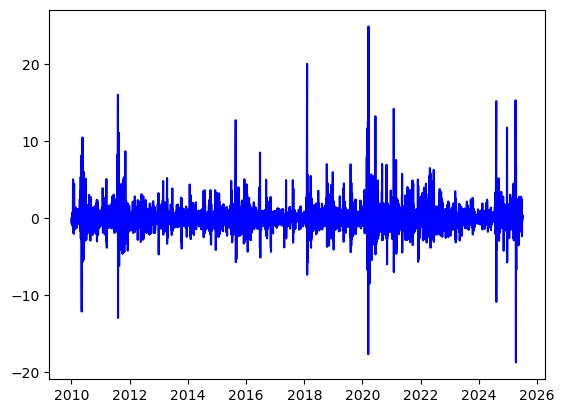

In [15]:
plt.plot(df.date, df.log_return, color = 'green')
plt.plot(df.date, df['vix_dif'], color = 'blue')

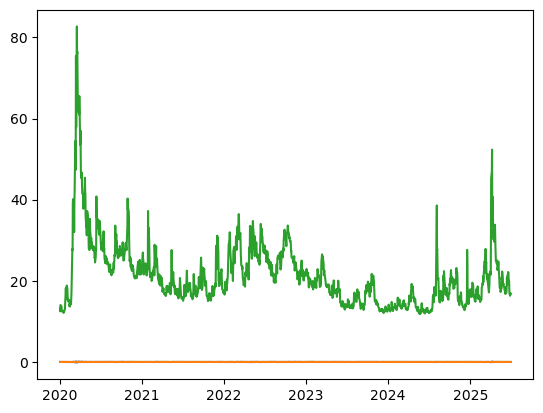

In [16]:
plt.plot(df.loc[df['date'].dt.year >= 2020].date, df.loc[df['date'].dt.year >= 2020].log_return)
plt.plot(df.loc[df['date'].dt.year >= 2020].date, df.loc[df['date'].dt.year >= 2020].daily_variance)
plt.plot(df.loc[df['date'].dt.year >= 2020].date, df.loc[df['date'].dt.year >= 2020].vix)

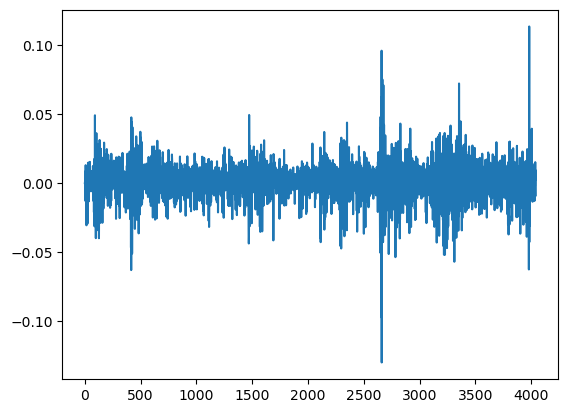

In [17]:
plt.plot(df['log_return'])

In [18]:
window = 90
garch_vols = []
df2 = df.loc[df['date'].dt.year.isin([2023])]

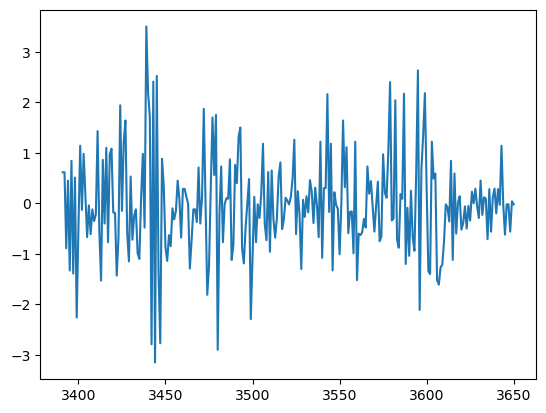

In [19]:
plt.plot(df2['vix_dif'])

In [20]:
for i in range(window, len(df2)):
    ret_window = df2["log_return"].iloc[i - window:i] * 100
    model = arch_model(ret_window, vol="GARCH", p=1, q=1, dist="normal")
    res = model.fit(disp="off")
    forecast = res.forecast(horizon=1)
    vol = np.sqrt(forecast.variance.values[-1][0])  # daily σ
    garch_vols.append(vol)


In [21]:
len(garch_vols)

170

In [22]:
df.head()

,date,close,return,log_return,daily_variance,rolling_var7,vix,vix_dif,period,effr,rate_change_positive,rate_change_negative
0,2010-01-01,1886.70,NaN,NaN,NaN,NaN,20.04,NaN,2010-01,0.11,0,0
1,2010-01-04,1886.70,0.000000,0.000000,0.000000e+00,NaN,20.04,0.00,2010-01,0.11,0,0
2,2010-01-05,1888.43,-0.000917,0.000917,8.400177e-07,NaN,19.35,-0.69,2010-01,0.11,0,0
3,2010-01-06,1878.42,0.005301,-0.005315,2.824708e-05,NaN,19.16,-0.19,2010-01,0.11,0,0
4,2010-01-07,1876.72,0.000905,-0.000905,8.197957e-07,NaN,19.06,-0.10,2010-01,0.11,0,0


In [23]:
df2 = df2.iloc[window:].copy()
df2["GARCH_vol"] = garch_vols


In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feat_cols = ['log_return','GARCH_vol','vix_dif','effr']
df2[feat_cols] = scaler.fit_transform(df2[feat_cols])


In [25]:


def create_sequences(data, hist_len=90, horizon=30):
    X, y = [], []
    arr = data.values
    for i in range(len(arr) - hist_len - horizon + 1):
        X.append(arr[i : i + hist_len])
        y.append(arr[i + hist_len : i + hist_len + horizon, 0])  # target = LogRet
    return np.array(X), np.array(y)

X, y = create_sequences(df2[feat_cols])


In [26]:
import torch
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

split = int(len(X) * 0.8)
train_ds = SeqDataset(X[:split], y[:split])
test_ds  = SeqDataset(X[split:], y[split:])

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32)


In [27]:
import torch.nn as nn

class LSTMForecaster(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=3, horizon=30):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers, batch_first=True, dropout=0.2)
        self.fc   = nn.Linear(hidden_size, horizon)
    def forward(self, x):
        # x: [batch, seq_len, input_size]
        out, _ = self.lstm(x)        
        # take last timestep's output
        out = out[:, -1, :]          
        return self.fc(out)         

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = LSTMForecaster(input_size=len(feat_cols)).to(device)


In [28]:
import torch.optim as optim

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs    = 15

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch}/{epochs} · Train MSE: {avg_loss:.6f}")


Epoch 1/15 · Train MSE: 0.324319
Epoch 2/15 · Train MSE: 0.313605
Epoch 3/15 · Train MSE: 0.286571
Epoch 4/15 · Train MSE: 0.256914
Epoch 5/15 · Train MSE: 0.223719
Epoch 6/15 · Train MSE: 0.164740
Epoch 7/15 · Train MSE: 0.099725
Epoch 8/15 · Train MSE: 0.076827
Epoch 9/15 · Train MSE: 0.093436
Epoch 10/15 · Train MSE: 0.080910
Epoch 11/15 · Train MSE: 0.062927
Epoch 12/15 · Train MSE: 0.053132
Epoch 13/15 · Train MSE: 0.049280
Epoch 14/15 · Train MSE: 0.050655
Epoch 15/15 · Train MSE: 0.054217


In [29]:
df2.head()

,date,close,return,log_return,daily_variance,rolling_var7,vix,vix_dif,period,effr,rate_change_positive,rate_change_negative,GARCH_vol
3481,2023-05-08,13291.64,-0.002452,0.543719,0.000006,0.000102,16.98,0.422764,2023-05,0.0,0,0,0.743789
3482,2023-05-09,13201.11,0.006811,0.359895,0.000047,0.000105,17.71,0.613821,2023-05,0.0,0,0,0.644779
3483,2023-05-10,13347.83,-0.011114,0.714093,0.000122,0.000124,16.94,0.308943,2023-05,0.0,0,0,0.575958
3484,2023-05-11,13389.78,-0.003143,0.557363,0.000010,0.000104,16.93,0.463415,2023-05,0.0,0,0,0.505992
3485,2023-05-12,13340.18,0.003704,0.421739,0.000014,0.000096,17.03,0.485772,2023-05,0.0,0,0,0.482668


In [30]:
model.eval()
# use last 90 days for prediction
last_seq = torch.tensor(
    df2[feat_cols].values[-90:], dtype=torch.float32
).unsqueeze(0).to(device) 

with torch.no_grad():
    pred = model(last_seq).cpu().numpy().flatten()

#inverse-scale log-returns
scale, min_ = scaler.scale_[0], scaler.min_[0]
pred_logret = pred / scale - min_ / scale

# rebuild price path
last_price = df2["close"].iloc[-1]
cum        = np.cumsum(pred_logret)
price_fc   = last_price * np.exp(pred)* .64

In [31]:
df2[feat_cols]

,log_return,GARCH_vol,vix_dif,effr
3481,0.543719,0.743789,0.422764,0.0
3482,0.359895,0.644779,0.613821,0.0
3483,0.714093,0.575958,0.308943,0.0
3484,0.557363,0.505992,0.463415,0.0
3485,0.421739,0.482668,0.485772,0.0
...,...,...,...,...
3646,0.554776,0.325521,0.461382,1.0
3647,0.554597,0.264428,0.461382,1.0
3648,0.528447,0.173129,0.351626,1.0
3649,0.485468,0.086928,0.473577,1.0


In [32]:
import pandas as pd
dates = pd.bdate_range(df2['date'].iloc[-1] + pd.Timedelta(1, "D"), periods = 30)
forecast = pd.Series(price_fc, index=dates, name="LSTM_PyTorch_FC")
print(forecast)

2024-01-01    17482.779534
2024-01-02    15742.425706
2024-01-03    17433.928983
2024-01-04    16660.122599
2024-01-05    17323.769412
2024-01-08    15992.700375
2024-01-09    17005.655457
2024-01-10    17028.038339
2024-01-11    17365.642963
2024-01-12    18044.917742
2024-01-15    17322.178887
2024-01-16    17593.222806
2024-01-17    18036.266776
2024-01-18    17849.724784
2024-01-19    16905.956892
2024-01-22    16887.051598
2024-01-23    16592.343647
2024-01-24    17141.453415
2024-01-25    17933.326827
2024-01-26    17973.223455
2024-01-29    17499.923569
2024-01-30    16988.737356
2024-01-31    15992.333232
2024-02-01    15724.291926
2024-02-02    17082.406304
2024-02-05    18030.552953
2024-02-06    16293.331394
2024-02-07    16097.022887
2024-02-08    17799.426201
2024-02-09    18582.510005
Freq: B, Name: LSTM_PyTorch_FC, dtype: float64


In [33]:
forecast = pd.DataFrame(forecast)

In [34]:
forecast = forecast.reset_index()
forecast

,index,LSTM_PyTorch_FC
0,2024-01-01,17482.779534
1,2024-01-02,15742.425706
2,2024-01-03,17433.928983
3,2024-01-04,16660.122599
4,2024-01-05,17323.769412
5,2024-01-08,15992.700375
6,2024-01-09,17005.655457
7,2024-01-10,17028.038339
8,2024-01-11,17365.642963
9,2024-01-12,18044.917742


In [35]:
forecast['index'] = pd.to_datetime(forecast['index'], format = '%Y-%m-%d')

In [36]:
forecast = forecast.rename(columns = {'index':'date', 'LSTM_PyTorch_FC':'model_close'})
forecast['model_close'] = forecast['model_close'] 


In [37]:
df.loc[~df['date'].isin(list(forecast['date']))]

,date,close,return,log_return,daily_variance,rolling_var7,vix,vix_dif,period,effr,rate_change_positive,rate_change_negative
0,2010-01-01,1886.70,NaN,NaN,NaN,NaN,20.04,NaN,2010-01,0.11,0,0
1,2010-01-04,1886.70,0.000000,0.000000,0.000000e+00,NaN,20.04,0.00,2010-01,0.11,0,0
2,2010-01-05,1888.43,-0.000917,0.000917,8.400177e-07,NaN,19.35,-0.69,2010-01,0.11,0,0
3,2010-01-06,1878.42,0.005301,-0.005315,2.824708e-05,NaN,19.16,-0.19,2010-01,0.11,0,0
4,2010-01-07,1876.72,0.000905,-0.000905,8.197957e-07,NaN,19.06,-0.10,2010-01,0.11,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4038,2025-06-25,22237.74,-0.002128,0.002126,4.518494e-06,0.000072,16.76,-0.72,2025-06,4.33,0,0
4039,2025-06-26,22447.29,-0.009423,0.009379,8.796655e-05,0.000048,16.59,-0.17,2025-06,4.33,0,0
4040,2025-06-27,22534.20,-0.003872,0.003864,1.493251e-05,0.000044,16.32,-0.27,2025-06,4.33,0,0
4041,2025-06-30,22679.01,-0.006426,0.006406,4.103263e-05,0.000034,16.73,0.41,2025-06,4.33,0,0


In [38]:
mod_vs_act = df.loc[df['date'].isin(list(forecast['date']))]
mod_vs_act = pd.merge(left = mod_vs_act, right = forecast, how = 'left', left_on = 'date', right_on = forecast['date'])

(array([19723., 19730., 19737., 19744., 19754., 19761.]),
 [Text(19723.0, 0, '2024-01-01'),
  Text(19730.0, 0, '2024-01-08'),
  Text(19737.0, 0, '2024-01-15'),
  Text(19744.0, 0, '2024-01-22'),
  Text(19754.0, 0, '2024-02-01'),
  Text(19761.0, 0, '2024-02-08')])

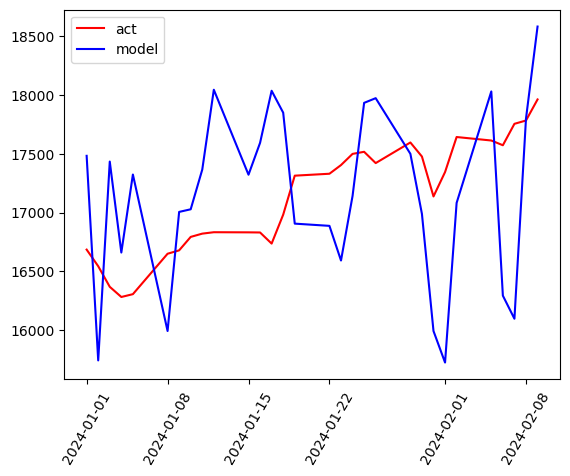

In [39]:
plt.plot(mod_vs_act['date'], mod_vs_act['close'], color = 'red', label = 'act')
plt.plot(mod_vs_act['date'], mod_vs_act['model_close'], color = 'blue', label = 'model')
plt.legend()
plt.xticks(rotation=60)

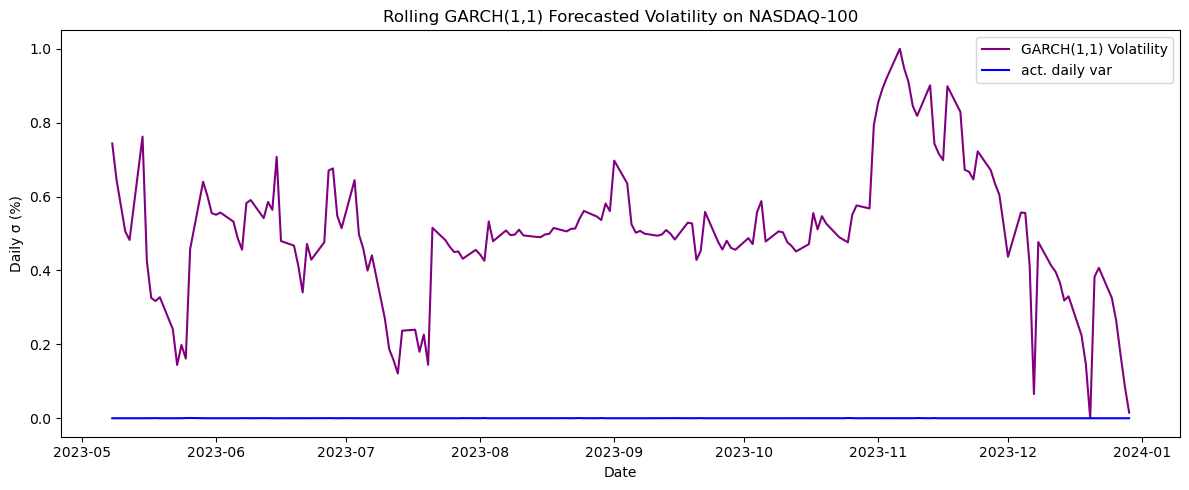

In [40]:
plt.figure(figsize=(12,5))
plt.plot(df2['date'], df2["GARCH_vol"], label="GARCH(1,1) Volatility", color="purple")
plt.plot(df2['date'], df2['daily_variance'], label = 'act. daily var', color = 'blue')
plt.title("Rolling GARCH(1,1) Forecasted Volatility on NASDAQ-100")
plt.ylabel("Daily σ (%)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


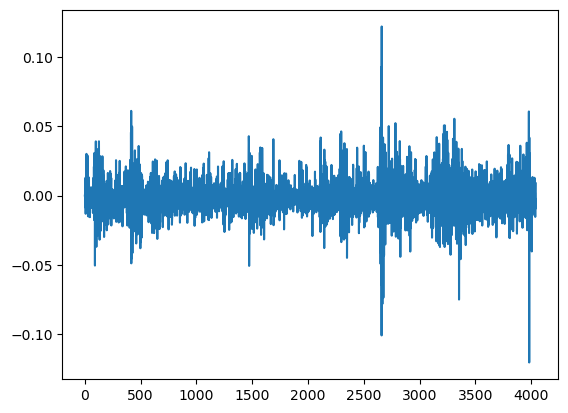

In [41]:
plt.plot(df['return'])
plt.show()